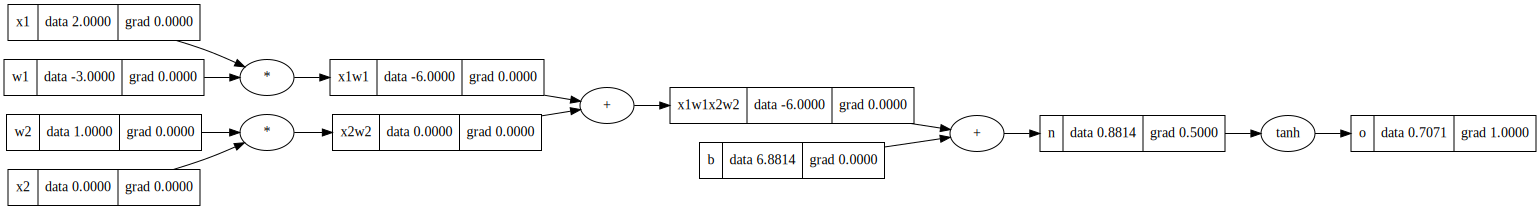

In [24]:
from graphviz import Source,Digraph
import math

class Value:
    def __init__(self,data,_children=(),op="",label=""):
        
        # if list then multiple pointers to same child may occur : not needed???
        
        self.data=data
        self._gradient=lambda:None
        self._prev=set(_children)
        self.grad=0
        self._op=op
        self.label=label
        
    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self,second):
        out= Value(self.data+second.data,(self,second),"+")
        def _gradient():
            self.grad=1*out.grad
            second.grad=1*out.grad
            
        out._gradient=_gradient
        #calling function to calculate gradient of output wrt self and second storing in grad attribute of self and second
        return out
    
    def __mul__(self,second):
        out= Value(self.data*second.data,(self,second),"*")
        def _gradient():
            self.grad=second.data*out.grad
            second.grad=self.data*out.grad
        out._gradient=_gradient
        return out   
    # def __pow__(self,second):
    #     return Value(self.data**second.data,(self,second),"**")
    
    # def __sub__(self,second):
    #     return Value(self.data-second.data, (self,second),"-")

    
    def tanh(self):
        
        x=self.data
        t=(math.exp(2*x)-1)/( math.exp(2*x)+1)
        out=Value(t,(self,),"tanh")
        def _gradient():
            self.grad=(1-t**2)*out.grad
            
        out._gradient=_gradient
        return out


#input nodes
x1=Value(2.0,label="x1")
x2=Value(0.0,label="x2")

#weights
w1=Value(-3.0,label="w1")
w2=Value(1.0,label="w2")

# bias of neuron
b=Value(6.88137,label="b")

# x1*w1+x2*w2+b (sigma xi*wi+b) where b is bias

x1w1=x1*w1
x1w1.label="x1w1"

x2w2=x2*w2
x2w2.label="x2w2"

x1w1x2w2=x1w1+x2w2
x1w1x2w2.label="x1w1x2w2"

n=x1w1x2w2+b
n.label="n"
o=n.tanh()
o.label="o"
o.grad=1
o._gradient()

draw_dot(o)


In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

